In [5]:
from pyspark.sql import SparkSession
from pyspark.mllib.classification import SVMWithSGD
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=1ba17bbc2d8f4c1753c4509aeafdfe5f5bde790aa8258b69a93a9709ddc6cd56
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [6]:
spark = SparkSession.builder.appName("SVMWithSGD").getOrCreate()


In [8]:
data = spark.read.csv("/content/Pumpkin_Seeds_Dataset.csv", header=True, inferSchema=True)

#string indexer
from pyspark.ml.feature import  StringIndexer
indexer = StringIndexer(inputCol="Class", outputCol="Class1")
indexed_data = indexer.fit(data).transform(data)

#vector assembler
indexed_data = indexed_data.drop("Class")
feature_columns = indexed_data.columns[:-1]
indexed_data.select(*feature_columns).show(5)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features1")
indexed_data = assembler.transform(indexed_data)


+-----+---------+-----------------+-----------------+-----------+--------------+------------+--------+------+---------+-------------+-----------+
| Area|Perimeter|Major_Axis_Length|Minor_Axis_Length|Convex_Area|Equiv_Diameter|Eccentricity|Solidity|Extent|Roundness|Aspect_Ration|Compactness|
+-----+---------+-----------------+-----------------+-----------+--------------+------------+--------+------+---------+-------------+-----------+
|56276|  888.242|         326.1485|         220.2388|      56831|      267.6805|      0.7376|  0.9902|0.7453|   0.8963|       1.4809|     0.8207|
|76631| 1068.146|         417.1932|         234.2289|      77280|      312.3614|      0.8275|  0.9916|0.7151|    0.844|       1.7811|     0.7487|
|71623| 1082.987|         435.8328|         211.0457|      72663|      301.9822|      0.8749|  0.9857|  0.74|   0.7674|       2.0651|     0.6929|
|66458|  992.051|         381.5638|         222.5322|      67118|      290.8899|      0.8123|  0.9902|0.7396|   0.8486|     

In [10]:
indexed_data.show()

+-----+---------+-----------------+-----------------+-----------+--------------+------------+--------+------+---------+-------------+-----------+------+--------------------+
| Area|Perimeter|Major_Axis_Length|Minor_Axis_Length|Convex_Area|Equiv_Diameter|Eccentricity|Solidity|Extent|Roundness|Aspect_Ration|Compactness|Class1|           features1|
+-----+---------+-----------------+-----------------+-----------+--------------+------------+--------+------+---------+-------------+-----------+------+--------------------+
|56276|  888.242|         326.1485|         220.2388|      56831|      267.6805|      0.7376|  0.9902|0.7453|   0.8963|       1.4809|     0.8207|   0.0|[56276.0,888.242,...|
|76631| 1068.146|         417.1932|         234.2289|      77280|      312.3614|      0.8275|  0.9916|0.7151|    0.844|       1.7811|     0.7487|   0.0|[76631.0,1068.146...|
|71623| 1082.987|         435.8328|         211.0457|      72663|      301.9822|      0.8749|  0.9857|  0.74|   0.7674|       2.06

In [11]:
#splitting data
train_data, test_data = indexed_data.randomSplit([0.7, 0.3], seed=42)

In [18]:
data.columns

['Area',
 'Perimeter',
 'Major_Axis_Length',
 'Minor_Axis_Length',
 'Convex_Area',
 'Equiv_Diameter',
 'Eccentricity',
 'Solidity',
 'Extent',
 'Roundness',
 'Aspect_Ration',
 'Compactness',
 'Class']

In [20]:
from pyspark.mllib.regression import LabeledPoint
columns=data.columns[:-1]
datacollect = train_data.collect()
data11 = []
for row in datacollect:
    data11.append(LabeledPoint(row["Class1"],[float(row[idx]) for idx in columns]))
datacollect1 = test_data.collect()
data1 = []
for row in datacollect1:
    data1.append(LabeledPoint(row["Class1"],[float(row[idx]) for idx in columns]))


In [21]:
from pyspark.sql import SparkSession
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

# training and test sets
train_data, test_data = data11, data1

# Convert lists to RDDs
train_data_rdd = spark.sparkContext.parallelize(train_data)
test_data_rdd = spark.sparkContext.parallelize(test_data)

# Train the SVM with SGD model
num_iterations = 100
model = SVMWithSGD.train(train_data_rdd, iterations=num_iterations)



In [22]:
# Make predictions on the test data
predictions = test_data_rdd.map(lambda point: (point.label, model.predict(point.features)))

# Calculate accuracy
accuracy = predictions.filter(lambda x: x[0] == x[1]).count() / float(test_data_rdd.count())
print("Accuracy:", accuracy)



Accuracy: 0.5158045977011494


696


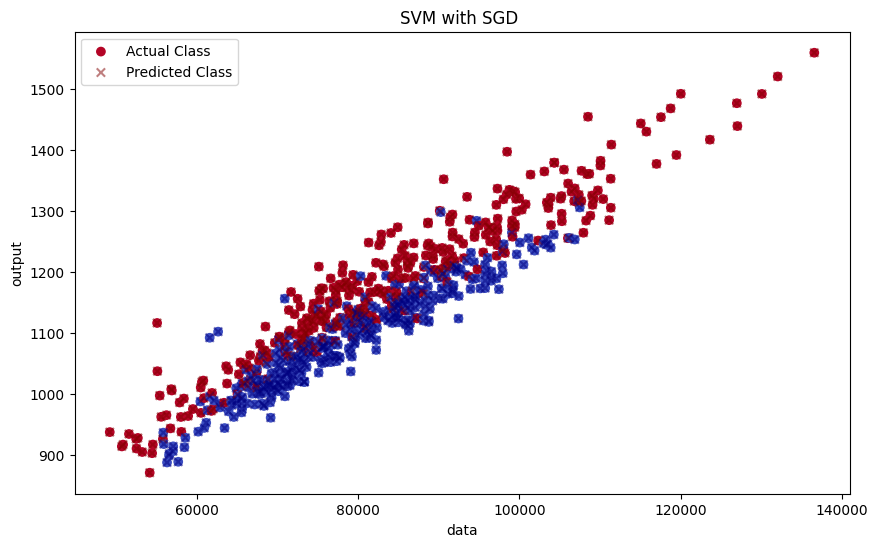

In [26]:
import matplotlib.pyplot as plt

# Indices of the features( 0 for 'Area' and 1 for 'Perimeter')
x_index = 0
y_index = 1



predictions_list = predictions.collect()
print(len(predictions_list))
l=[]
for i in range(0,696):
  l.append(predictions_list[i][0])
labels_list = [point.label for point in test_data]

# Extract the selected features
data_features = [(point.features[x_index], point.features[y_index]) for point in test_data]


plt.figure(figsize=(10, 6))
plt.scatter(*zip(*data_features), c=labels_list, marker='o', cmap='coolwarm', label='Actual Class')
plt.scatter(*zip(*data_features), c=l, marker='x', cmap='jet', label='Predicted Class',alpha=0.5)

plt.xlabel("data")
plt.ylabel("output")
plt.legend()
plt.title('SVM with SGD ')
plt.show()